# Train Data - 13,000 Single Point Edit Mutations!
In this notebook, we find all 13,000 pairs of proteins in the train dataset that are single point edit mutations of each other. We ignore type `insertion` and `deletion` and only find `edit`. Then we build a simple statistical model that uses this train data to predict test data. We begin with my notebook [here][2] that found groups (i.e. clusters) of train data that are very similar to each other (i.e. plus or minus 10 mutations of insert, delete, or edit). Then we search within these groups for single point edit mutation pairs.

As I was writing this notebook, I see that Vladimir @vslaykovsky has also written and published a similar notebook [here][1]. Please check out his notebook. His notebook uses a different creative and efficient technique and finds all single point mutations of type `insertion`, `deletion`, and `edit`. He also keeps pairs with different pH values whereas I remove those.

As a sanity check, I compared the output of this notebook with the output of Vladimir's notebook. This notebook finds 12918 pairs of single point edit mutations in the train dataset (with same pH). And Vladimir's notebook finds 12759 pairs of single point edit mutations (with same pH) using a completely different method. Our matching results support the conclusion that train data most likely has 13,000 pairs (of single edit same pH) and we have more or less found them all.

### UPDATE v2: 

My first attempt (notebook version 1) inferring test predictions from train statistics did not score well on LB. Perhaps different data sources cause the target `tm` to change independent of mutation which would negatively affect test preds. In version 2 of this notebook, I added columns identifying the data source of the train proteins. There are 4,000 pairs where both proteins are from same data source instead of 13,000 pairs. In this notebook, we will restrict the computation of train statistics to pairs from the same data source. Let's hope this helps CV LB...

[1]: https://www.kaggle.com/code/vslaykovsky/nesp-single-mutations-training-set
[2]: https://www.kaggle.com/code/cdeotte/train-data-contains-mutations-like-test-data

# Load Train Data with Groups
We load the output file from my previous notebook [here][1] which is the train data with a new column `group` identifying similar train proteins.

[1]: https://www.kaggle.com/code/cdeotte/train-data-contains-mutations-like-test-data

In [1]:
VER = 2

import cudf, numpy as np, pandas as pd
train = cudf.read_csv('../input/train-data-contains-mutations-like-test-data/train_with_groups.csv')
train = train.loc[train.group!=-1]
train.pH = train.pH.fillna(-1)
train['len'] = train.protein_sequence.str.len() 
print( train.shape )
train.head()

(7316, 7)


,seq_id,protein_sequence,pH,data_source,tm,group,len
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.4,130,380
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,45.7,130,380
31,31,AATSVFCGSSHRQLHHAVIPHGKGGRSSVSGVVATVFGATGFLGRY...,7.0,doi.org/10.1038/s41592-020-0801-4,40.8,281,354
69,69,ADLEDNWETLNDNLKVIEKADNAAQVKDALTKARAAALDAQKATPP...,5.0,<NA>,25.0,67,106
70,70,ADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPP...,5.0,<NA>,25.0,67,106


In [2]:
vc = train.group.value_counts()
print('Number of groups',len(vc))
print('Group number and their counts:')
vc.head()

Number of groups 408
Group number and their counts:


5     816
9     783
15    308
34    211
27    196
Name: group, dtype: int32

# Find Single Point Edit Mutations
Here we use a simple for-loop to iteration through the 408 groups. Within each group we find all pairs of single point edit mutations using RAPIDS string method `edit_distance_matrix()`.

In [3]:
rows = []

print(f'Processing {len(vc)-1} groups...')
for k in range(len(vc)-1):
    print('#'*25)
    ct = vc.iloc[k]
    print('### group',k+1,'with ct=',ct)
    print('#'*25)

    # COMPUTE LEVENSHTEIN DISTANCE WITHIN GROUPS
    grp = vc.index[k]
    tmp = train.loc[train.group==grp]
    d = tmp.protein_sequence.str.edit_distance_matrix()
    d = np.array( d.to_pandas().values.tolist() )
    idx_x = np.where( d==1 )[0]
    idx_y = np.where( d==1 )[1]

    # FIND PAIRS WITHIN GROUPS
    print(f'Processing {len(idx_x)} pairs...')
    for i,(x,y) in enumerate(zip(idx_x,idx_y)):
        if i%100==0: print(i,', ',end='')
        # DONT DOUBLE COUNT PAIRS
        if y<=x: continue
        row1 = tmp.iloc[x]
        row2 = tmp.iloc[y]
        # IGNORE MUTATIONS WITH DIFFERENT PH
        if row1.pH.values[0] != row2.pH.values[0]: continue
        # IGNORE INSERT AND DELETE MUTATIONS
        if row1['len'].values[0] != row2['len'].values[0]: continue
        dd = {}
        dd['seq1'] = row1.protein_sequence.to_pandas().values[0]
        dd['tm1'] = row1.tm.values[0]
        dd['ds1'] = row1.data_source.to_pandas().values[0]
        dd['seq2'] = row2.protein_sequence.to_pandas().values[0]
        dd['tm2'] = row2.tm.values[0]
        dd['ds2'] = row2.data_source.to_pandas().values[0]
        dd['pH'] = row1.pH.values[0]
        dd['len'] = row1['len'].values[0]
        dd['group'] = row1.group.values[0]
        rows.append(dd)
    print()

Processing 407 groups...
#########################
### group 1 with ct= 816
#########################
Processing 10392 pairs...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 
#########################
### group 2 with ct= 783
#########################
Processing 5830 pairs...
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800

In [4]:
print('All pairs of train single point edit mutations:')
df = pd.DataFrame(rows)
print('Dataframe shape',df.shape)
df.head()

All pairs of train single point edit mutations:
Dataframe shape (12918, 9)


,seq1,tm1,ds1,seq2,tm2,ds2,pH,len,group
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,41.9,None,2.0,164,5
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,35.4,10.1038/334406a0,2.0,164,5
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,37.8,10.1038/334406a0,2.0,164,5
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,33.1,10.1021/bi00159a009,2.0,164,5
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNFFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,34.1,10.1021/bi00159a009,2.0,164,5


# Locate Mutation Position

In [5]:
def get_mutation(row):
    for i,(a,b) in enumerate(zip(row.seq1,row.seq2)):
        if a!=b: break
    row['AA1'] = row.seq1[i]
    row['AA2'] = row.seq2[i]
    row['position'] = i
    return row

df = df.apply(get_mutation,axis=1)
df.to_csv(f'train_single_edit_mutations_v{VER}.csv',index=False)
df.head()

,seq1,tm1,ds1,seq2,tm2,ds2,pH,len,group,AA1,AA2,position
0,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,41.9,None,2.0,164,5,A,C,2
1,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNDFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,35.4,10.1038/334406a0,2.0,164,5,A,D,2
2,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,37.8,10.1038/334406a0,2.0,164,5,A,E,2
3,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNEFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,33.1,10.1021/bi00159a009,2.0,164,5,A,E,2
4,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,38.1,10.1021/bi00535a054,MNFFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,34.1,10.1021/bi00159a009,2.0,164,5,A,F,2


# Compute Train Statistics
Each pair of mutation proteins differ by one amino acid. For example maybe `D` gets changed into `M`. For each pair of amino acids, we compute the average change in target `tm` among all pairs of mutations with those two amino acids changing from one to the other. All pairs of proteins have the same `pH` with their partner, so we have isolated the affect of amino acid mutation without `pH` affecting our statistics.

UPDATE: In version 2 of this notebook, we will only use pairs where both proteins come from the same data source to compute train mutation statistics. Let's hope that improves CV LB score...

In [6]:
# FIND TRAIN PAIRS WHERE BOTH PROTEINS SAME DATA SOURCE
df = df.loc[df.ds1==df.ds2]
print('Number of pairs with same data source =',df.shape[0])

Number of pairs with same data source = 3816


In [7]:
# COMPUTE TRAIN PAIR MUTATION STATISTICS (same pH, same data source)
AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
mut_sum = np.zeros((20,20))
mut_ct = np.ones((20,20))

for i,x in enumerate(AA):
    print(f'{i}-{x}, ',end='')
    for j,y in enumerate(AA):
        tmp = df.loc[(df.AA1==x)&(df.AA2==y)]
        if len(tmp)==0: continue
        mut_ct[i,j] = len(tmp)
        mut_sum[i,j] = tmp.tm2.sum() - tmp.tm1.sum()
        
mut_ct = mut_ct + mut_ct.T
mut_sum = mut_sum - mut_sum.T
mut_mean = mut_sum / mut_ct

0-A, 1-C, 2-D, 3-E, 4-F, 5-G, 6-H, 7-I, 8-K, 9-L, 10-M, 11-N, 12-P, 13-Q, 14-R, 15-S, 16-T, 17-V, 18-W, 19-Y, 

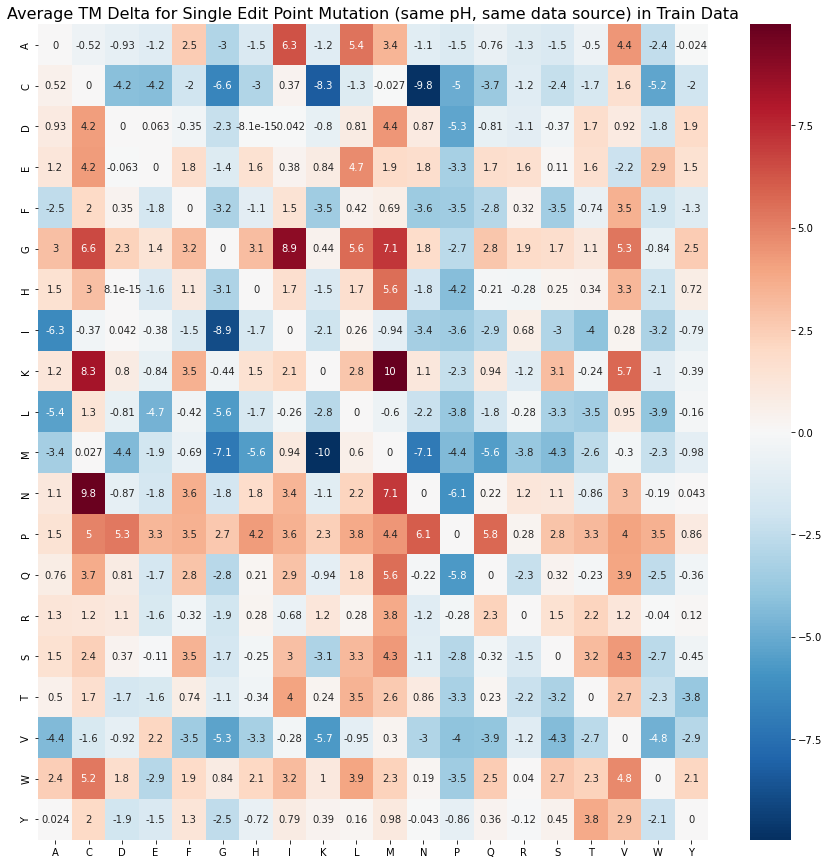

In [8]:
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(mut_mean, cmap='RdBu_r', annot=True, center=0.0)
plt.xticks(np.arange(20)+0.5,AA)
plt.yticks(np.arange(20)+0.5,AA)
plt.title('Average TM Delta for Single Edit Point Mutation (same pH, same data source) in Train Data',size=16)
plt.show()

# Predict Test Data
We will now use the train statistics we computed above to predict the affect of test mutations.

In [9]:
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [10]:
test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv')
print( test.shape )
test.head()

(2413, 4)


,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [11]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['AA1'] = base[i]
    row['AA2'] = row.protein_sequence[i]
    row['position'] = i
    return row

test = test.apply(get_test_mutation,axis=1)
test.head()

,seq_id,protein_sequence,pH,data_source,AA1,AA2,position
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,E,16
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,K,16
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,L,K,16
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,C,17
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,F,17


In [12]:
AA_map = {x:y for x,y in zip(AA,np.arange(20))}
print( AA_map )

def get_prediction(row):
    dtm = mut_mean[AA_map[row.AA1],AA_map[row.AA2]]
    return dtm

test['tm'] = test.apply(get_prediction,axis=1)
test.head()

{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


,seq_id,protein_sequence,pH,data_source,AA1,AA2,position,tm
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,E,16,-4.677273
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,K,16,-2.781818
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,L,K,16,-2.781818
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,C,17,8.263636
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,F,17,3.516667


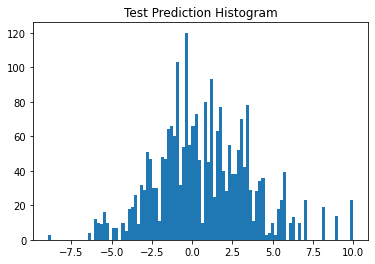

In [13]:
test[['seq_id','tm']].to_csv(f'submission_v{VER}.csv',index=False)
plt.hist(test.tm,bins=100)
plt.title('Test Prediction Histogram')
plt.show()